In [1]:
# Uninstall problematic versions
!pip uninstall -y numpy opencv-python albumentations

# Install compatible versions
!pip install numpy==1.23.5 opencv-python==4.7.0.72 albumentations==1.3.0

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: opencv-python 4.11.0.86
Uninstalling opencv-python-4.11.0.86:
  Successfully uninstalled opencv-python-4.11.0.86
Found existing installation: albumentations 2.0.6
Uninstalling albumentations-2.0.6:
  Successfully uninstalled albumentations-2.0.6
INFO: pip is looking at multiple versions of scikit-image to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 32.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.25.2
    Uninstalling scikit-image-0.25.2:
      Successfully uninst

In [9]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, balanced_accuracy_score
from albumentations.pytorch import ToTensorV2
import albumentations as A
from PIL import Image
import kagglehub
dataset_path = kagglehub.dataset_download('jessicali9530/stanford-dogs-dataset')

In [2]:
# ==== Step 1: Albumentations Transforms ====
def get_transforms(train=True):
    if train:
        return A.Compose([
            A.Resize(224, 224),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
            A.Normalize(mean=(0.485, 0.456, 0.406),
                        std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])
    else:
        return A.Compose([
            A.Resize(224, 224),
            A.Normalize(mean=(0.485, 0.456, 0.406),
                        std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])

In [3]:
# ==== Step 2: Albumentations Dataset Wrapper ====
class AlbumentationsDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        img = np.array(img)
        if self.transform:
            img = self.transform(image=img)['image']
        return img, label

In [4]:
# ==== Step 3: Base Model Class ====
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        _, preds = torch.max(out, dim=1)
        return {
            'val_loss': loss.detach(),
            'preds': preds.cpu(),
            'labels': labels.cpu()
        }

    def validation_epoch_end(self, outputs):
        val_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(val_losses).mean().item()
        all_preds = torch.cat([x['preds'] for x in outputs])
        all_labels = torch.cat([x['labels'] for x in outputs])

        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='macro')
        kappa = cohen_kappa_score(all_labels, all_preds)
        bal_acc = balanced_accuracy_score(all_labels, all_preds)

        return {
            'val_loss': epoch_loss,
            'val_acc': acc,
            'val_f1': f1,
            'val_kappa': kappa,
            'val_bal_acc': bal_acc
        }

    def epoch_end(self, epoch, result):
        print(f"Epoch [{epoch}], "
              f"Train Loss: {result['train_loss']:.4f}, "
              f"Val Loss: {result['val_loss']:.4f}, "
              f"Acc: {result['val_acc']:.4f}, "
              f"F1: {result['val_f1']:.4f}, "
              f"Kappa: {result['val_kappa']:.4f}, "
              f"Balanced Acc: {result['val_bal_acc']:.4f}")

In [5]:
# ==== Step 4: Custom CNN with SE Attention ====
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.global_avgpool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class CNNWithAttention(ImageClassificationBase):
    def __init__(self, num_classes):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            SEBlock(32),
            nn.MaxPool2d(2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            SEBlock(64),
            nn.MaxPool2d(2)
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            SEBlock(128),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, num_classes)
        )

    def forward(self, xb):
        x = self.conv_block1(xb)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        return self.classifier(x)

In [6]:
# ==== Step 5: Device Helpers ====
def get_default_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [7]:
# ==== Step 6: Training Utilities ====
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [10]:
# ==== Step 7: Load Dataset and Create Train/Test Split ====

full_dataset = ImageFolder(dataset_path + '/images/Images')
all_labels = [sample[1] for sample in full_dataset.samples]

# Train/test split (stratified)
train_indices, test_indices = train_test_split(
    np.arange(len(all_labels)),
    test_size=0.2,
    stratify=all_labels,
    random_state=42
)

train_dataset = Subset(full_dataset, train_indices)
test_dataset = Subset(full_dataset, test_indices)

In [11]:
# ==== Step 8: Apply Stratified K-Fold on Training Set Only ====
device = get_default_device()
train_labels = [all_labels[i] for i in train_indices]

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(train_labels)), train_labels)):
    print(f"\n--- Fold {fold+1} ---")

    # Create Subsets from the original training subset
    fold_train_subset = Subset(train_dataset, train_idx)
    fold_val_subset = Subset(train_dataset, val_idx)

    # Albumentations Datasets
    train_ds = AlbumentationsDataset(fold_train_subset, transform=get_transforms(train=True))
    val_ds = AlbumentationsDataset(fold_val_subset, transform=get_transforms(train=False))
    test_ds = AlbumentationsDataset(test_dataset, transform=get_transforms(train=False))

    # DataLoaders
    train_loader = DeviceDataLoader(DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2, pin_memory=True), device)
    val_loader = DeviceDataLoader(DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2, pin_memory=True), device)
    test_loader = DeviceDataLoader(DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2, pin_memory=True), device)

    # Model and Training
    model = to_device(CNNWithAttention(num_classes=len(full_dataset.classes)), device)
    history = fit(epochs=10, lr=1e-3, model=model, train_loader=train_loader, val_loader=val_loader)

    # Optional: Evaluate on test set after final fold
    test_result = evaluate(model, test_loader)
    print(f"\nTest results after Fold {fold+1}: {test_result}")



--- Fold 1 ---
Epoch [0], Train Loss: 4.7410, Val Loss: 4.6700, Acc: 0.0233, F1: 0.0050, Kappa: 0.0133, Balanced Acc: 0.0192
Epoch [1], Train Loss: 4.6339, Val Loss: 4.5877, Acc: 0.0308, F1: 0.0094, Kappa: 0.0208, Balanced Acc: 0.0263
Epoch [2], Train Loss: 4.5401, Val Loss: 4.5289, Acc: 0.0368, F1: 0.0160, Kappa: 0.0276, Balanced Acc: 0.0338
Epoch [3], Train Loss: 4.4686, Val Loss: 4.4775, Acc: 0.0415, F1: 0.0184, Kappa: 0.0325, Balanced Acc: 0.0381
Epoch [4], Train Loss: 4.4091, Val Loss: 4.5009, Acc: 0.0399, F1: 0.0208, Kappa: 0.0307, Balanced Acc: 0.0367
Epoch [5], Train Loss: 4.3482, Val Loss: 4.3829, Acc: 0.0528, F1: 0.0304, Kappa: 0.0440, Balanced Acc: 0.0492
Epoch [6], Train Loss: 4.2906, Val Loss: 4.3729, Acc: 0.0517, F1: 0.0338, Kappa: 0.0428, Balanced Acc: 0.0477
Epoch [7], Train Loss: 4.2368, Val Loss: 4.3092, Acc: 0.0691, F1: 0.0433, Kappa: 0.0610, Balanced Acc: 0.0674
Epoch [8], Train Loss: 4.1800, Val Loss: 4.2933, Acc: 0.0660, F1: 0.0419, Kappa: 0.0575, Balanced Acc: 0

In [16]:
from google.colab import drive
import os
import torch

# ==== Step 1: Mount Google Drive ====
drive.mount('/content/drive')

# ==== Step 2: Define a save path ====
SAVE_PATH = "/content/drive/MyDrive/saved_models"
os.makedirs(SAVE_PATH, exist_ok=True)

# Change 'model_fold1.pth' as needed
model_save_path = os.path.join(SAVE_PATH, 'cnn_with_attention_fold1.pth')

# ==== Step 3: Save model weights ====
torch.save(model.state_dict(), model_save_path)

print(f"✅ Model weights saved to: {model_save_path}")

Mounted at /content/drive
✅ Model weights saved to: /content/drive/MyDrive/saved_models/cnn_with_attention_fold1.pth


In [ ]:
# Recreate the model architecture first
model = CNNWithAttention(num_classes=len(full_dataset.classes))
model.load_state_dict(torch.load(model_save_path))
model.to(device)
model.eval()

✅ Predicted Label: n02085936-Maltese_dog
🎯 Actual Label: n02085782-Japanese_spaniel


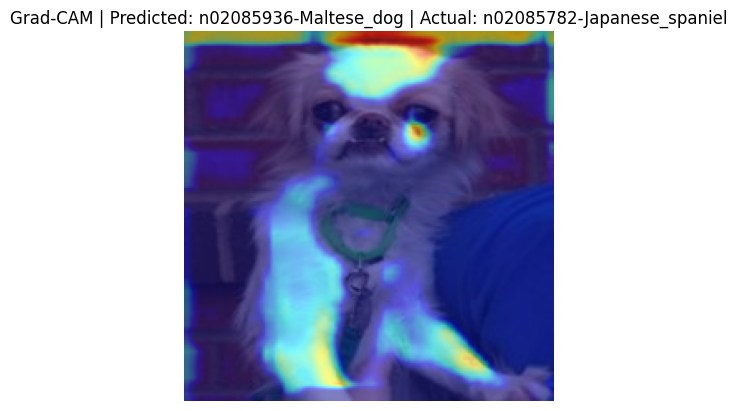

In [15]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import matplotlib.pyplot as plt
import cv2

# ==== Step 1: Pick an image from dataset ====
index = 202  # Change as needed
first_img, actual_label = full_dataset[index]
img_np = np.array(first_img)

# ==== Step 2: Preprocess ====
val_transform = get_transforms(train=False)
input_tensor = val_transform(image=img_np)['image'].unsqueeze(0).to(device)

# ==== Step 3: Set target layer ====
# Use the last conv layer from your custom CNN
target_layer = model.conv_block3[0]  # This is Conv2d in conv_block3

# ==== Step 4: Initialize Grad-CAM ====
cam = GradCAM(model=model, target_layers=[target_layer])

# ==== Step 5: Forward + prediction ====
model.eval()
output = model(input_tensor)
pred_class = output.argmax(dim=1).item()
targets = [ClassifierOutputTarget(pred_class)]

# ==== Step 6: Compute Grad-CAM ====
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

# ==== Step 7: Resize and overlay ====
resized_img = cv2.resize(img_np, (224, 224))
rgb_img = resized_img.astype(np.float32) / 255.0  # Normalize to [0, 1]
cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# ==== Step 8: Display ====
predicted_label_name = full_dataset.classes[pred_class]
actual_label_name = full_dataset.classes[actual_label]

print(f"✅ Predicted Label: {predicted_label_name}")
print(f"🎯 Actual Label: {actual_label_name}")

plt.imshow(cam_image)
plt.title(f"Grad-CAM | Predicted: {predicted_label_name} | Actual: {actual_label_name}")
plt.axis('off')
plt.show()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


  0%|          | 0/100 [00:00<?, ?it/s]

✅ Predicted Label: n02085936-Maltese_dog
🎯 Actual Label: n02085782-Japanese_spaniel


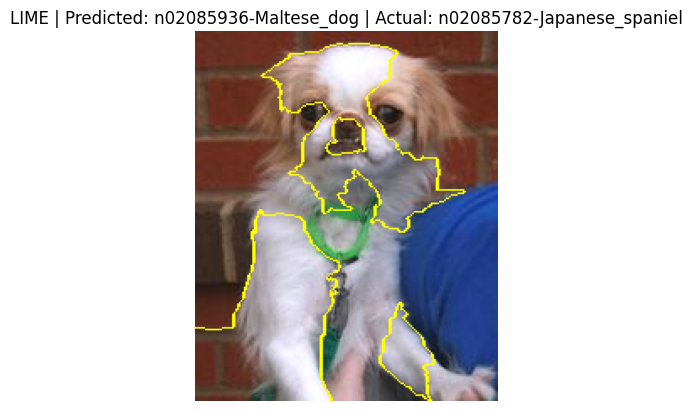

In [17]:
!pip install lime --quiet

from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# ==== Step 1: Get image and label from dataset ====
index = 202  # Change index to test different images
first_img, actual_label = full_dataset[index]
img_np = np.array(first_img)  # Convert to NumPy array

# ==== Step 2: Define prediction function for LIME ====
def batch_predict(images):
    model.eval()
    # Apply Albumentations transform to each image
    batch = torch.stack([
        val_transform(image=img)['image'] for img in images
    ], dim=0).to(device)

    with torch.no_grad():
        logits = model(batch)
        probs = F.softmax(logits, dim=1).detach().cpu().numpy()
    return probs

# ==== Step 3: Run LIME explainer ====
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    image=img_np,
    classifier_fn=batch_predict,
    top_labels=1,
    hide_color=0,
    num_samples=100  # More samples = better, but slower
)

# ==== Step 4: Get prediction and mask for top class ====
pred_class = batch_predict([img_np]).argmax()
lime_image_np, mask = explanation.get_image_and_mask(
    label=pred_class,
    positive_only=True,
    hide_rest=False,
    num_features=10,
    min_weight=0.0
)

# ==== Step 5: Display the LIME explanation ====
predicted_label_name = full_dataset.classes[pred_class]
actual_label_name = full_dataset.classes[actual_label]

print(f"✅ Predicted Label: {predicted_label_name}")
print(f"🎯 Actual Label: {actual_label_name}")

plt.imshow(mark_boundaries(lime_image_np, mask))
plt.title(f"LIME | Predicted: {predicted_label_name} | Actual: {actual_label_name}")
plt.axis('off')
plt.show()
